In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


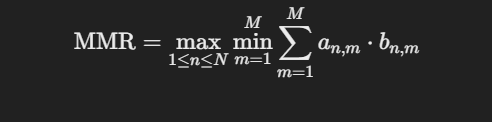

# MMR 10*10

Subset 1: Logistic Regression = 1.64, Decision Tree = 1.64, Random Forest = 1.64, kNN = 2.02
Subset 2: Logistic Regression = 0.0, Decision Tree = 0.0, Random Forest = 0.0, kNN = 2.28
Subset 3: Logistic Regression = 1.12, Decision Tree = 1.12, Random Forest = 1.12, kNN = 1.12
Subset 4: Logistic Regression = 1.59, Decision Tree = 1.59, Random Forest = 1.59, kNN = 0.77
Subset 5: Logistic Regression = 0.0, Decision Tree = 0.0, Random Forest = 0.0, kNN = 0.75
Subset 6: Logistic Regression = 1.57, Decision Tree = 1.57, Random Forest = 1.57, kNN = 1.92
Subset 7: Logistic Regression = 1.79, Decision Tree = 0.87, Random Forest = 1.79, kNN = 0.0
Subset 8: Logistic Regression = 0.0, Decision Tree = 0.0, Random Forest = 0.0, kNN = 0.0
Subset 9: Logistic Regression = 0.0, Decision Tree = 0.0, Random Forest = 0.0, kNN = 0.0
Subset 10: Logistic Regression = 0.0, Decision Tree = 0.0, Random Forest = 0.0, kNN = 0.0

Average Minimum Maximization Reward (MMR) across all subsets:
Logistic Regression: 0.77

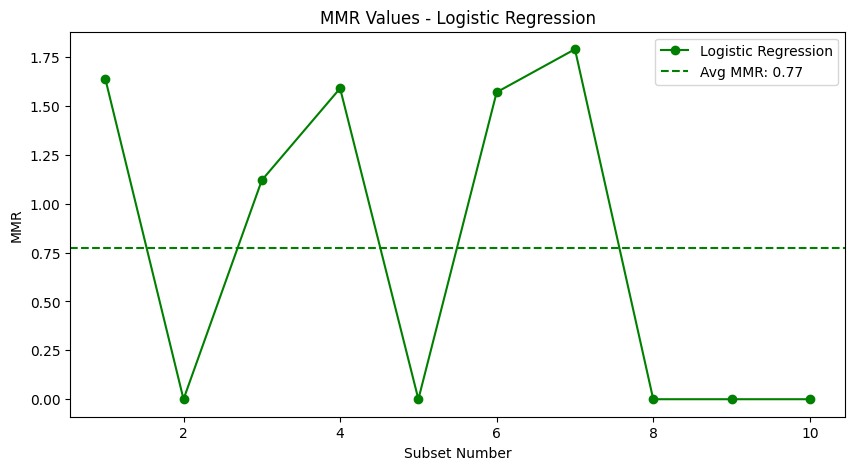

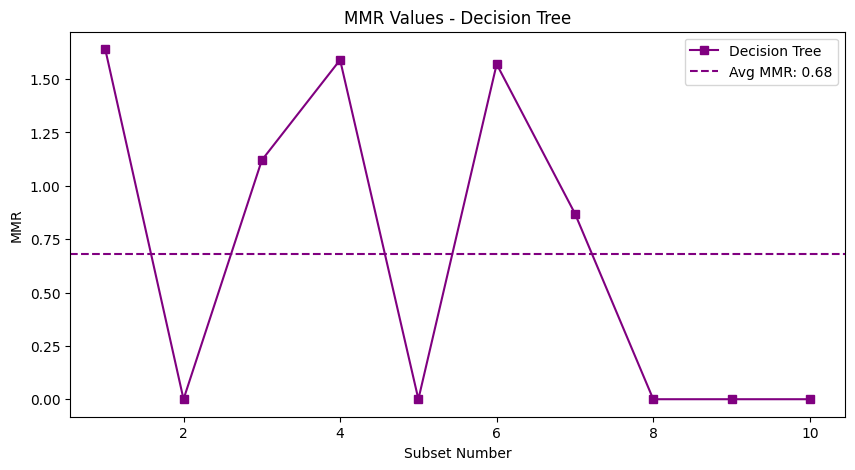

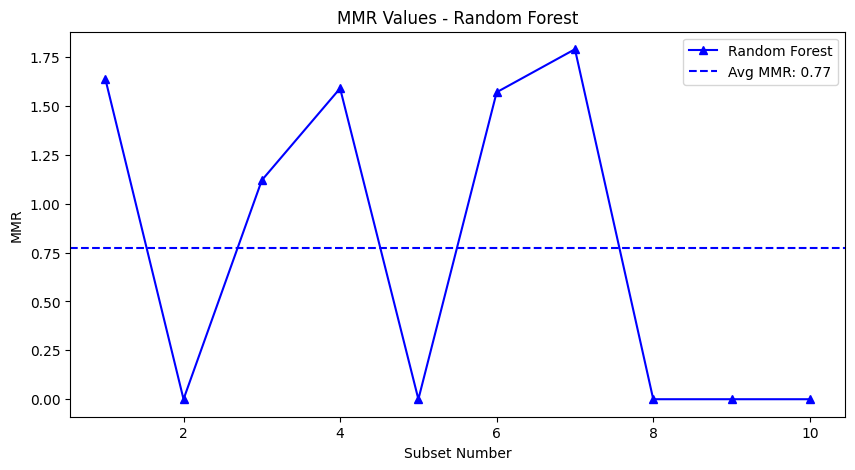

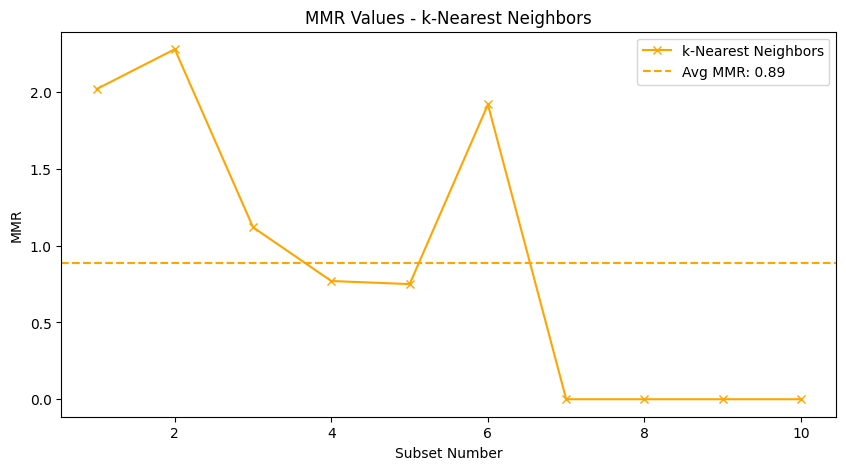

Text(0.5, 1.0, 'Average MMR')

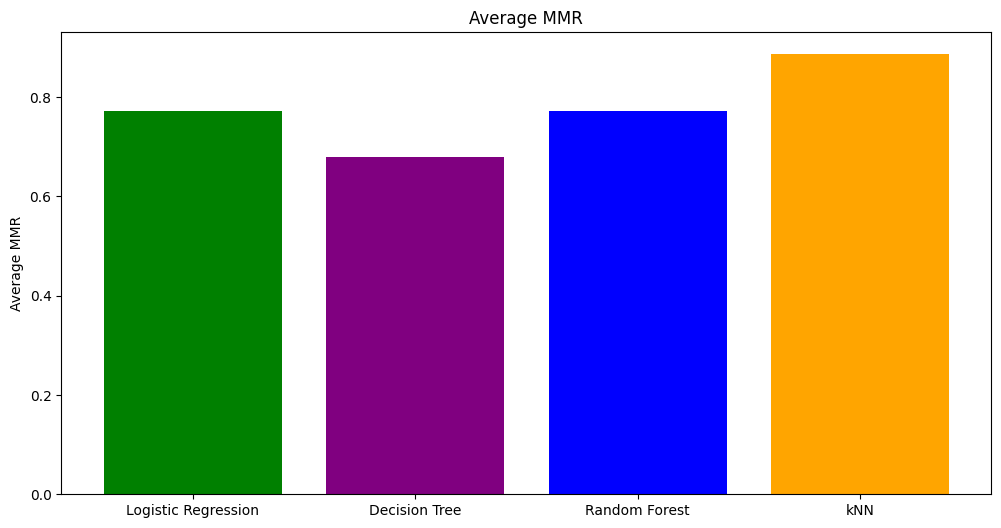

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import cvxpy as cp

# Define the subset size and number of subsets
subset_size = 10
num_subsets = 10

# Load the channel matrix and reward matrix from CSV files
C_full = pd.read_csv("/content/drive/MyDrive/finalyr/channel_matrix.csv", header=None).values
R_full = pd.read_csv("/content/drive/MyDrive/finalyr/reward_matrix.csv", header=None).values

# Normalize the reward matrix to the range [0, 1]
R_normalized_full = R_full / 100.0

# Initialize lists to store MMR rewards for each classifier
logistic_mmr_rewards = []
decision_tree_mmr_rewards = []
random_forest_mmr_rewards = []
knn_mmr_rewards = []

# Function to calculate MMR for a reward matrix
def calculate_mmr(R, k=3):
    num_users, num_channels = R.shape

    # Decision variable: binary selection matrix
    a = cp.Variable((num_users, num_channels), boolean=True)

    # Minimum reward for each user
    user_rewards = cp.sum(cp.multiply(a, R), axis=1)

    # Objective: Maximize the minimum reward across users
    min_user_reward = cp.min(user_rewards)
    objective = cp.Maximize(min_user_reward)

    # Constraints: Each user selects exactly k channels
    constraints = [cp.sum(a, axis=1) == k]

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    if problem.status == cp.OPTIMAL:
        return min_user_reward.value
    else:
        return None

# Loop to sample and evaluate 10 random 10x10 subsets
for i in range(num_subsets):
    # Randomly select the top-left corner of a 10x10 subset
    start_row = np.random.randint(0, C_full.shape[0] - subset_size)
    start_col = np.random.randint(0, C_full.shape[1] - subset_size)

    # Extract the 10x10 subset from the full matrices
    C = C_full[start_row:start_row + subset_size, start_col:start_col + subset_size]
    R = R_full[start_row:start_row + subset_size, start_col:start_col + subset_size]
    R_normalized = R_normalized_full[start_row:start_row + subset_size, start_col:start_col + subset_size]

    # Flatten the matrices for model training
    C_flat = C.flatten()  # Channel values
    R_flat = R_normalized.flatten()  # Normalized reward values

    # Define binary classification target: high reward (1) vs. low reward (0)
    threshold = 0.5
    R_target = (R_flat > threshold).astype(int)  # Convert rewards to binary based on threshold

    # Prepare the feature matrix and standardize it
    X = C_flat.reshape(-1, 1)  # Channel values as single-feature input
    y = R_target  # Binary reward target
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Logistic Regression model
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    y_pred_logistic = log_reg.predict(X).reshape(subset_size, subset_size)
    logistic_predicted_reward_matrix = np.where(y_pred_logistic == 1, R_normalized, 0)
    logistic_mmr_reward = calculate_mmr(logistic_predicted_reward_matrix)
    logistic_mmr_rewards.append(logistic_mmr_reward)

    # Decision Tree model
    tree_clf = DecisionTreeClassifier(random_state=42)
    tree_clf.fit(X_train, y_train)
    y_pred_tree = tree_clf.predict(X).reshape(subset_size, subset_size)
    tree_predicted_reward_matrix = np.where(y_pred_tree == 1, R_normalized, 0)
    tree_mmr_reward = calculate_mmr(tree_predicted_reward_matrix)
    decision_tree_mmr_rewards.append(tree_mmr_reward)

    # Random Forest model
    rf_clf = RandomForestClassifier(random_state=42)
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X).reshape(subset_size, subset_size)
    rf_predicted_reward_matrix = np.where(y_pred_rf == 1, R_normalized, 0)
    rf_mmr_reward = calculate_mmr(rf_predicted_reward_matrix)
    random_forest_mmr_rewards.append(rf_mmr_reward)

    # k-Nearest Neighbors model
    knn_clf = KNeighborsClassifier(n_neighbors=3)  # Example k=3
    knn_clf.fit(X_train, y_train)
    y_pred_knn = knn_clf.predict(X).reshape(subset_size, subset_size)
    knn_predicted_reward_matrix = np.where(y_pred_knn == 1, R_normalized, 0)
    knn_mmr_reward = calculate_mmr(knn_predicted_reward_matrix)
    knn_mmr_rewards.append(knn_mmr_reward)

    # Print the MMR for this subset for each model
    print(f"Subset {i+1}: Logistic Regression = {logistic_mmr_reward}, Decision Tree = {tree_mmr_reward}, Random Forest = {rf_mmr_reward}, kNN = {knn_mmr_reward}")

# Calculate the average MMR across all subsets for each model
avg_logistic_mmr_reward = np.mean(logistic_mmr_rewards)
avg_tree_mmr_reward = np.mean(decision_tree_mmr_rewards)
avg_rf_mmr_reward = np.mean(random_forest_mmr_rewards)
avg_knn_mmr_reward = np.mean(knn_mmr_rewards)

# Print the average MMR for each model
print("\nAverage Minimum Maximization Reward (MMR) across all subsets:")
print(f"Logistic Regression: {avg_logistic_mmr_reward}")
print(f"Decision Tree: {avg_tree_mmr_reward}")
print(f"Random Forest: {avg_rf_mmr_reward}")
print(f"k-Nearest Neighbors: {avg_knn_mmr_reward}")

# Plotting MMR values for Logistic Regression
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_subsets + 1), logistic_mmr_rewards, marker='o', color='green', label="Logistic Regression")
plt.axhline(y=avg_logistic_mmr_reward, color="green", linestyle="--", label=f"Avg MMR: {avg_logistic_mmr_reward:.2f}")
plt.xlabel("Subset Number")
plt.ylabel("MMR")
plt.title("MMR Values - Logistic Regression")
plt.legend()
plt.show()

# Plotting MMR values for Decision Tree
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_subsets + 1), decision_tree_mmr_rewards, marker='s', color='purple', label="Decision Tree")
plt.axhline(y=avg_tree_mmr_reward, color="purple", linestyle="--", label=f"Avg MMR: {avg_tree_mmr_reward:.2f}")
plt.xlabel("Subset Number")
plt.ylabel("MMR")
plt.title("MMR Values - Decision Tree")
plt.legend()
plt.show()

# Plotting MMR values for Random Forest
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_subsets + 1), random_forest_mmr_rewards, marker='^', color='blue', label="Random Forest")
plt.axhline(y=avg_rf_mmr_reward, color="blue", linestyle="--", label=f"Avg MMR: {avg_rf_mmr_reward:.2f}")
plt.xlabel("Subset Number")
plt.ylabel("MMR")
plt.title("MMR Values - Random Forest")
plt.legend()
plt.show()

# Plotting MMR values for k-Nearest Neighbors
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_subsets + 1), knn_mmr_rewards, marker='x', color='orange', label="k-Nearest Neighbors")
plt.axhline(y=avg_knn_mmr_reward, color="orange", linestyle="--", label=f"Avg MMR: {avg_knn_mmr_reward:.2f}")
plt.xlabel("Subset Number")
plt.ylabel("MMR")
plt.title("MMR Values - k-Nearest Neighbors")
plt.legend()
plt.show()

# Overlay plot to compare the average MMR of all models
plt.figure(figsize=(12, 6))
plt.bar(['Logistic Regression', 'Decision Tree', 'Random Forest', 'kNN'],
        [avg_logistic_mmr_reward, avg_tree_mmr_reward, avg_rf_mmr_reward, avg_knn_mmr_reward],
        color=['green', 'purple', 'blue', 'orange'])
plt.ylabel("Average MMR")
plt.title("Average MMR")


# MMR 15*!5

Subset 1: Logistic Regression = 1.51, Decision Tree = 1.51, Random Forest = 1.51, kNN = 1.51
Subset 2: Logistic Regression = 2.2, Decision Tree = 2.2, Random Forest = 2.2, kNN = 2.2
Subset 3: Logistic Regression = 2.15, Decision Tree = 2.15, Random Forest = 2.15, kNN = 2.15
Subset 4: Logistic Regression = 1.19, Decision Tree = 1.19, Random Forest = 1.19, kNN = 1.19
Subset 5: Logistic Regression = 1.27, Decision Tree = 1.27, Random Forest = 1.27, kNN = 0.0
Subset 6: Logistic Regression = 2.29, Decision Tree = 2.29, Random Forest = 2.29, kNN = 1.15
Subset 7: Logistic Regression = 1.8599999999999999, Decision Tree = 1.8599999999999999, Random Forest = 1.8599999999999999, kNN = 1.8599999999999999
Subset 8: Logistic Regression = 0.0, Decision Tree = 0.0, Random Forest = 0.0, kNN = 1.5
Subset 9: Logistic Regression = 2.39, Decision Tree = 2.39, Random Forest = 2.39, kNN = 2.2199999999999998
Subset 10: Logistic Regression = 1.4, Decision Tree = 1.4, Random Forest = 1.4, kNN = 1.65000000000000

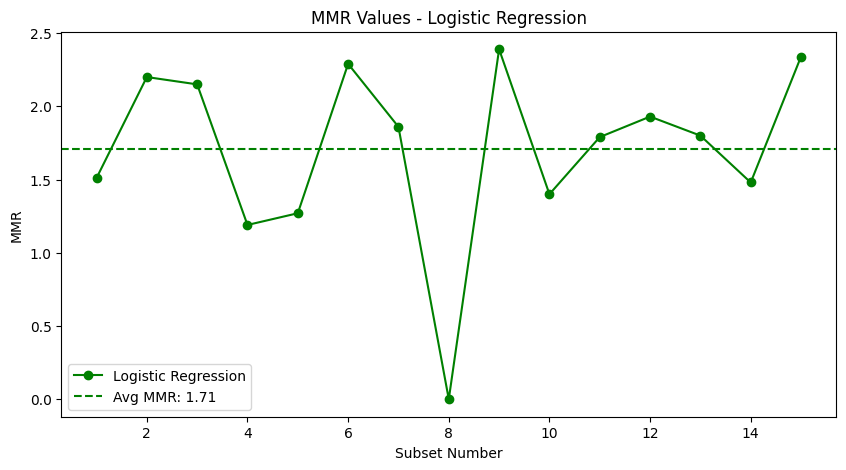

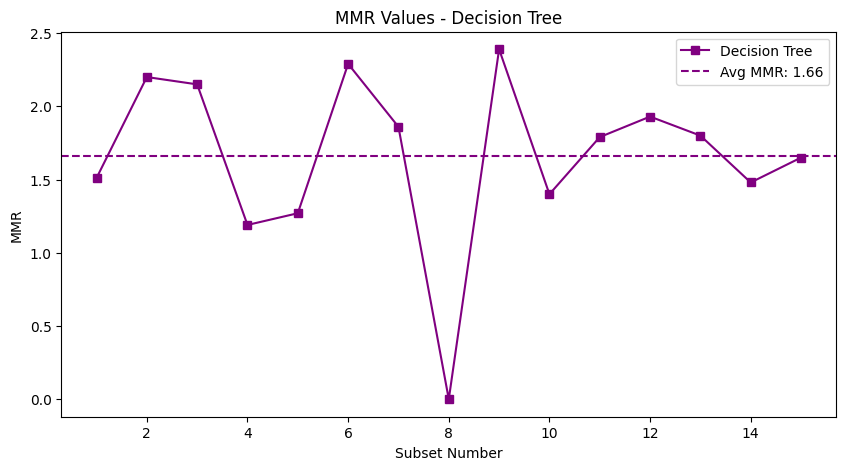

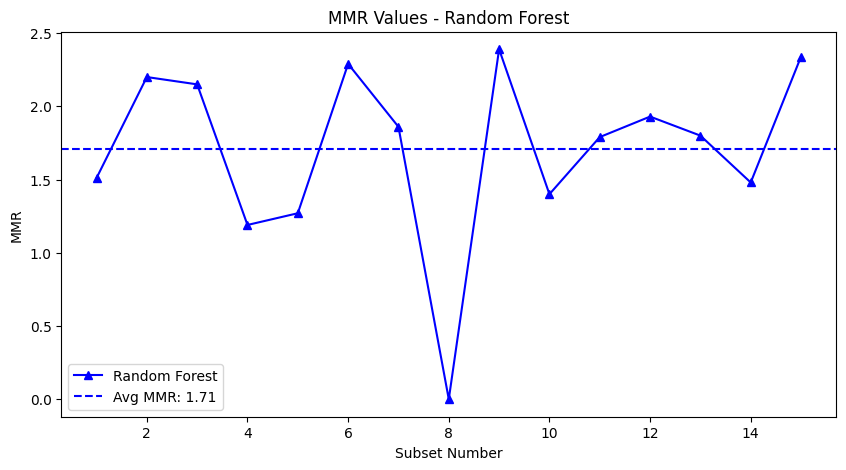

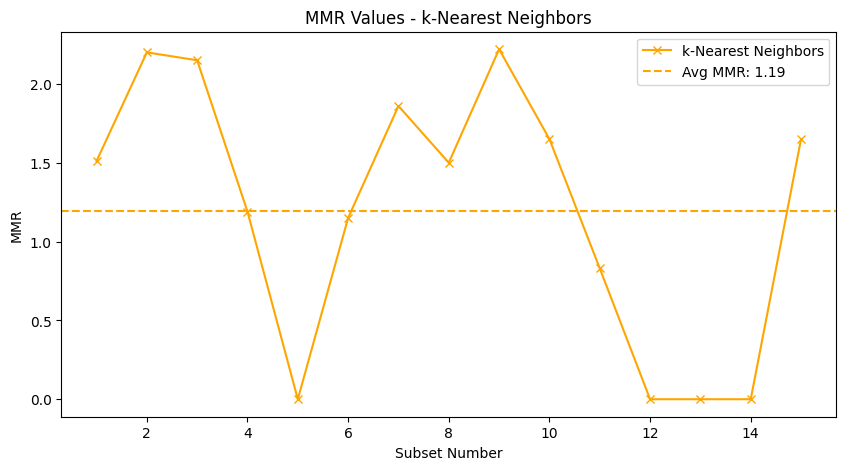

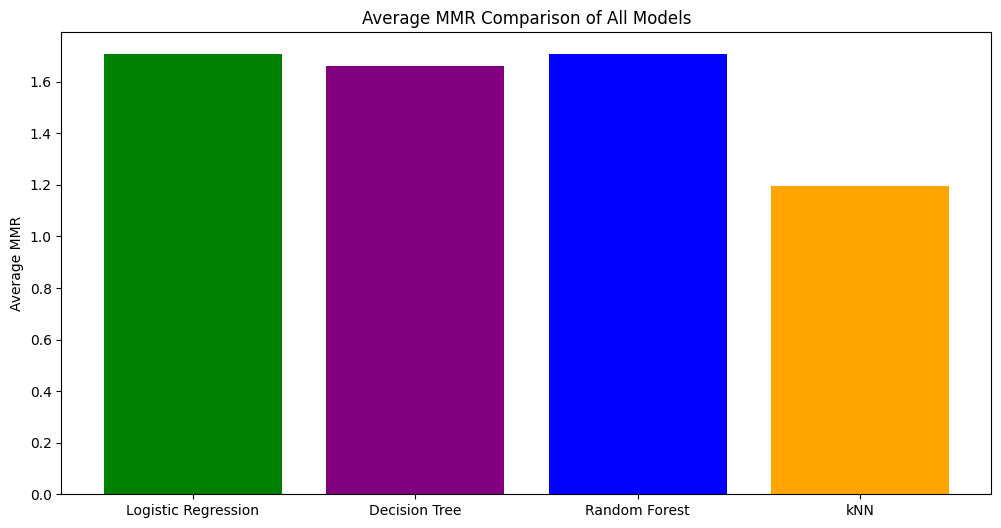

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import cvxpy as cp

# Define the subset size and number of subsets
subset_size = 15
num_subsets = 15

# Load the channel matrix and reward matrix from CSV files
C_full = pd.read_csv("/content/drive/MyDrive/finalyr/channel_matrix.csv", header=None).values
R_full = pd.read_csv("/content/drive/MyDrive/finalyr/reward_matrix.csv", header=None).values

# Normalize the reward matrix to the range [0, 1]
R_normalized_full = R_full / 100.0

# Initialize lists to store MMR rewards for each classifier
logistic_mmr_rewards = []
decision_tree_mmr_rewards = []
random_forest_mmr_rewards = []
knn_mmr_rewards = []

# Function to calculate MMR for a reward matrix
def calculate_mmr(R, k=3):
    num_users, num_channels = R.shape

    # Decision variable: binary selection matrix
    a = cp.Variable((num_users, num_channels), boolean=True)

    # Minimum reward for each user
    user_rewards = cp.sum(cp.multiply(a, R), axis=1)

    # Objective: Maximize the minimum reward across users
    min_user_reward = cp.min(user_rewards)
    objective = cp.Maximize(min_user_reward)

    # Constraints: Each user selects exactly k channels
    constraints = [cp.sum(a, axis=1) == k]

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    if problem.status == cp.OPTIMAL:
        return min_user_reward.value
    else:
        return None

# Loop to sample and evaluate 15 random 15x15 subsets
for i in range(num_subsets):
    # Randomly select the top-left corner of a 15x15 subset
    start_row = np.random.randint(0, C_full.shape[0] - subset_size)
    start_col = np.random.randint(0, C_full.shape[1] - subset_size)

    # Extract the 15x15 subset from the full matrices
    C = C_full[start_row:start_row + subset_size, start_col:start_col + subset_size]
    R = R_full[start_row:start_row + subset_size, start_col:start_col + subset_size]
    R_normalized = R_normalized_full[start_row:start_row + subset_size, start_col:start_col + subset_size]

    # Flatten the matrices for model training
    C_flat = C.flatten()  # Channel values
    R_flat = R_normalized.flatten()  # Normalized reward values

    # Define binary classification target: high reward (1) vs. low reward (0)
    threshold = 0.5
    R_target = (R_flat > threshold).astype(int)  # Convert rewards to binary based on threshold

    # Prepare the feature matrix and standardize it
    X = C_flat.reshape(-1, 1)  # Channel values as single-feature input
    y = R_target  # Binary reward target
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Logistic Regression model
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    y_pred_logistic = log_reg.predict(X).reshape(subset_size, subset_size)
    logistic_predicted_reward_matrix = np.where(y_pred_logistic == 1, R_normalized, 0)
    logistic_mmr_reward = calculate_mmr(logistic_predicted_reward_matrix)
    logistic_mmr_rewards.append(logistic_mmr_reward)

    # Decision Tree model
    tree_clf = DecisionTreeClassifier(random_state=42)
    tree_clf.fit(X_train, y_train)
    y_pred_tree = tree_clf.predict(X).reshape(subset_size, subset_size)
    tree_predicted_reward_matrix = np.where(y_pred_tree == 1, R_normalized, 0)
    tree_mmr_reward = calculate_mmr(tree_predicted_reward_matrix)
    decision_tree_mmr_rewards.append(tree_mmr_reward)

    # Random Forest model
    rf_clf = RandomForestClassifier(random_state=42)
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X).reshape(subset_size, subset_size)
    rf_predicted_reward_matrix = np.where(y_pred_rf == 1, R_normalized, 0)
    rf_mmr_reward = calculate_mmr(rf_predicted_reward_matrix)
    random_forest_mmr_rewards.append(rf_mmr_reward)

    # k-Nearest Neighbors model
    knn_clf = KNeighborsClassifier(n_neighbors=3)  # Example k=3
    knn_clf.fit(X_train, y_train)
    y_pred_knn = knn_clf.predict(X).reshape(subset_size, subset_size)
    knn_predicted_reward_matrix = np.where(y_pred_knn == 1, R_normalized, 0)
    knn_mmr_reward = calculate_mmr(knn_predicted_reward_matrix)
    knn_mmr_rewards.append(knn_mmr_reward)

    # Print the MMR for this subset for each model
    print(f"Subset {i+1}: Logistic Regression = {logistic_mmr_reward}, Decision Tree = {tree_mmr_reward}, Random Forest = {rf_mmr_reward}, kNN = {knn_mmr_reward}")

# Calculate the average MMR across all subsets for each model
avg_logistic_mmr_reward = np.mean(logistic_mmr_rewards)
avg_tree_mmr_reward = np.mean(decision_tree_mmr_rewards)
avg_rf_mmr_reward = np.mean(random_forest_mmr_rewards)
avg_knn_mmr_reward = np.mean(knn_mmr_rewards)

# Print the average MMR for each model
print("\nAverage Minimum Maximization Reward (MMR) across all subsets:")
print(f"Logistic Regression: {avg_logistic_mmr_reward}")
print(f"Decision Tree: {avg_tree_mmr_reward}")
print(f"Random Forest: {avg_rf_mmr_reward}")
print(f"k-Nearest Neighbors: {avg_knn_mmr_reward}")

# Plotting MMR values for Logistic Regression
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_subsets + 1), logistic_mmr_rewards, marker='o', color='green', label="Logistic Regression")
plt.axhline(y=avg_logistic_mmr_reward, color="green", linestyle="--", label=f"Avg MMR: {avg_logistic_mmr_reward:.2f}")
plt.xlabel("Subset Number")
plt.ylabel("MMR")
plt.title("MMR Values - Logistic Regression")
plt.legend()
plt.show()

# Plotting MMR values for Decision Tree
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_subsets + 1), decision_tree_mmr_rewards, marker='s', color='purple', label="Decision Tree")
plt.axhline(y=avg_tree_mmr_reward, color="purple", linestyle="--", label=f"Avg MMR: {avg_tree_mmr_reward:.2f}")
plt.xlabel("Subset Number")
plt.ylabel("MMR")
plt.title("MMR Values - Decision Tree")
plt.legend()
plt.show()

# Plotting MMR values for Random Forest
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_subsets + 1), random_forest_mmr_rewards, marker='^', color='blue', label="Random Forest")
plt.axhline(y=avg_rf_mmr_reward, color="blue", linestyle="--", label=f"Avg MMR: {avg_rf_mmr_reward:.2f}")
plt.xlabel("Subset Number")
plt.ylabel("MMR")
plt.title("MMR Values - Random Forest")
plt.legend()
plt.show()

# Plotting MMR values for k-Nearest Neighbors
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_subsets + 1), knn_mmr_rewards, marker='x', color='orange', label="k-Nearest Neighbors")
plt.axhline(y=avg_knn_mmr_reward, color="orange", linestyle="--", label=f"Avg MMR: {avg_knn_mmr_reward:.2f}")
plt.xlabel("Subset Number")
plt.ylabel("MMR")
plt.title("MMR Values - k-Nearest Neighbors")
plt.legend()
plt.show()

# Overlay plot to compare the average MMR of all models
plt.figure(figsize=(12, 6))
plt.bar(['Logistic Regression', 'Decision Tree', 'Random Forest', 'kNN'],
        [avg_logistic_mmr_reward, avg_tree_mmr_reward, avg_rf_mmr_reward, avg_knn_mmr_reward],
        color=['green', 'purple', 'blue', 'orange'])
plt.ylabel("Average MMR")
plt.title("Average MMR Comparison of All Models")
plt.show()


# MMR 20*20

Subset 1: Logistic Regression = 1.8299999999999998, Decision Tree = 1.8299999999999998, Random Forest = 1.8299999999999998, kNN = 2.42
Subset 2: Logistic Regression = 0.0, Decision Tree = 0.0, Random Forest = 0.0, kNN = 2.12
Subset 3: Logistic Regression = 1.75, Decision Tree = 1.75, Random Forest = 1.75, kNN = 1.75
Subset 4: Logistic Regression = 2.3600000000000003, Decision Tree = 2.3600000000000003, Random Forest = 2.3600000000000003, kNN = 2.3600000000000003
Subset 5: Logistic Regression = 1.53, Decision Tree = 1.53, Random Forest = 1.53, kNN = 1.15
Subset 6: Logistic Regression = 2.3, Decision Tree = 2.3, Random Forest = 2.3, kNN = 1.67
Subset 7: Logistic Regression = 2.23, Decision Tree = 2.23, Random Forest = 2.23, kNN = 1.42
Subset 8: Logistic Regression = 2.44, Decision Tree = 2.44, Random Forest = 2.44, kNN = 0.0
Subset 9: Logistic Regression = 2.47, Decision Tree = 2.47, Random Forest = 2.47, kNN = 2.47
Subset 10: Logistic Regression = 0.0, Decision Tree = 0.0, Random Forest

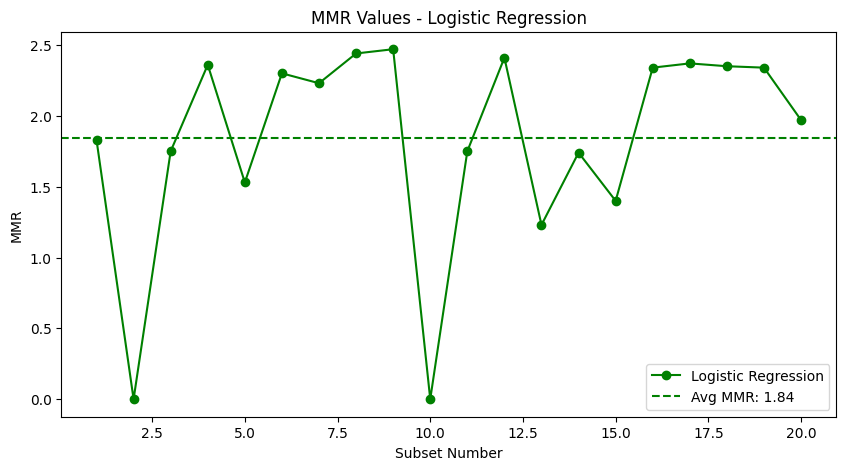

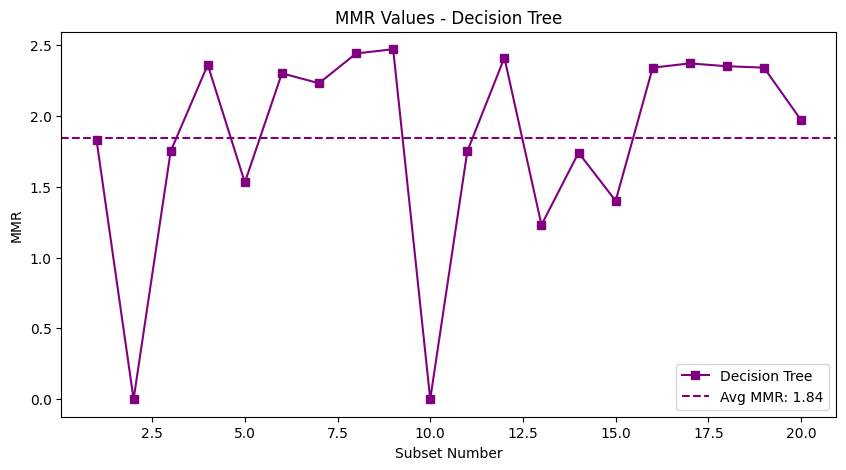

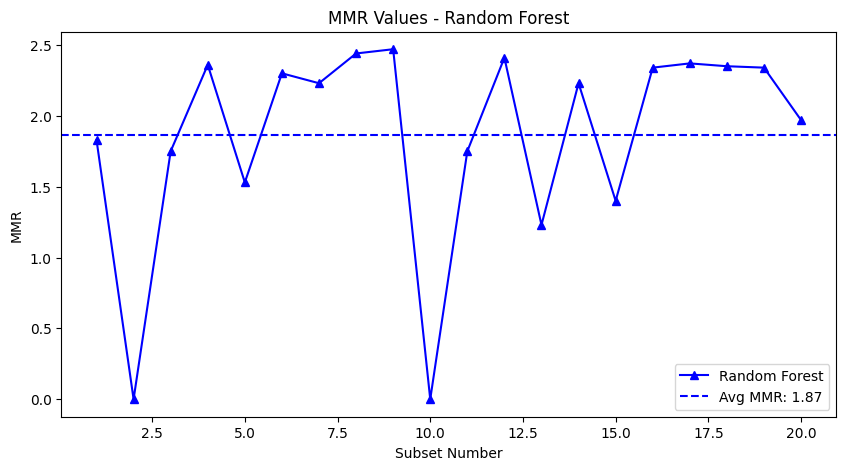

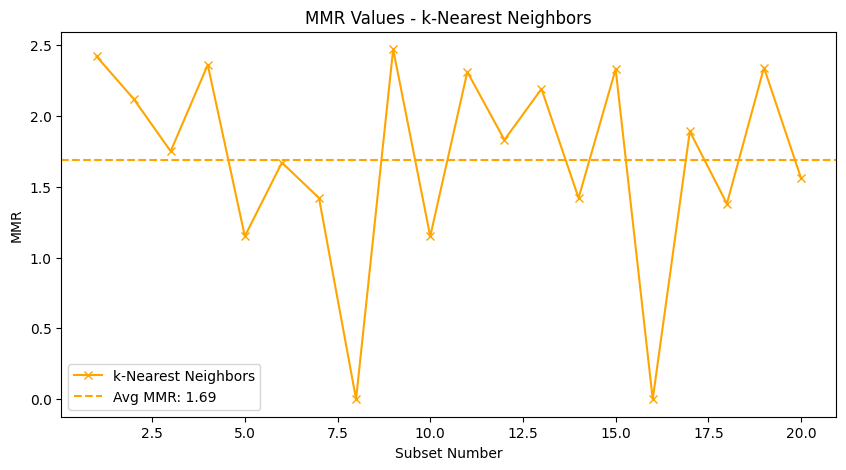

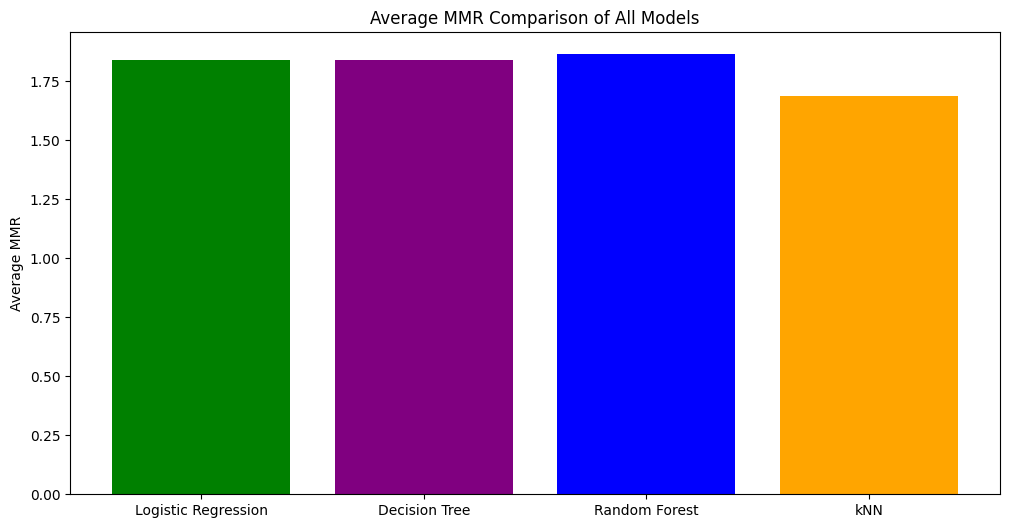

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import cvxpy as cp

# Define the subset size and number of subsets
subset_size = 20
num_subsets = 20

# Load the channel matrix and reward matrix from CSV files
C_full = pd.read_csv("/content/drive/MyDrive/finalyr/channel_matrix.csv", header=None).values
R_full = pd.read_csv("/content/drive/MyDrive/finalyr/reward_matrix.csv", header=None).values

# Normalize the reward matrix to the range [0, 1]
R_normalized_full = R_full / 100.0

# Initialize lists to store MMR rewards for each classifier
logistic_mmr_rewards = []
decision_tree_mmr_rewards = []
random_forest_mmr_rewards = []
knn_mmr_rewards = []

# Function to calculate MMR for a reward matrix
def calculate_mmr(R, k=3):
    num_users, num_channels = R.shape

    # Decision variable: binary selection matrix
    a = cp.Variable((num_users, num_channels), boolean=True)

    # Minimum reward for each user
    user_rewards = cp.sum(cp.multiply(a, R), axis=1)

    # Objective: Maximize the minimum reward across users
    min_user_reward = cp.min(user_rewards)
    objective = cp.Maximize(min_user_reward)

    # Constraints: Each user selects exactly k channels
    constraints = [cp.sum(a, axis=1) == k]

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    if problem.status == cp.OPTIMAL:
        return min_user_reward.value
    else:
        return None

# Loop to sample and evaluate 20 random 20x20 subsets
for i in range(num_subsets):
    # Randomly select the top-left corner of a 20x20 subset
    start_row = np.random.randint(0, C_full.shape[0] - subset_size)
    start_col = np.random.randint(0, C_full.shape[1] - subset_size)

    # Extract the 20x20 subset from the full matrices
    C = C_full[start_row:start_row + subset_size, start_col:start_col + subset_size]
    R = R_full[start_row:start_row + subset_size, start_col:start_col + subset_size]
    R_normalized = R_normalized_full[start_row:start_row + subset_size, start_col:start_col + subset_size]

    # Flatten the matrices for model training
    C_flat = C.flatten()  # Channel values
    R_flat = R_normalized.flatten()  # Normalized reward values

    # Define binary classification target: high reward (1) vs. low reward (0)
    threshold = 0.5
    R_target = (R_flat > threshold).astype(int)  # Convert rewards to binary based on threshold

    # Prepare the feature matrix and standardize it
    X = C_flat.reshape(-1, 1)  # Channel values as single-feature input
    y = R_target  # Binary reward target
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Logistic Regression model
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    y_pred_logistic = log_reg.predict(X).reshape(subset_size, subset_size)
    logistic_predicted_reward_matrix = np.where(y_pred_logistic == 1, R_normalized, 0)
    logistic_mmr_reward = calculate_mmr(logistic_predicted_reward_matrix)
    logistic_mmr_rewards.append(logistic_mmr_reward)

    # Decision Tree model
    tree_clf = DecisionTreeClassifier(random_state=42)
    tree_clf.fit(X_train, y_train)
    y_pred_tree = tree_clf.predict(X).reshape(subset_size, subset_size)
    tree_predicted_reward_matrix = np.where(y_pred_tree == 1, R_normalized, 0)
    tree_mmr_reward = calculate_mmr(tree_predicted_reward_matrix)
    decision_tree_mmr_rewards.append(tree_mmr_reward)

    # Random Forest model
    rf_clf = RandomForestClassifier(random_state=42)
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X).reshape(subset_size, subset_size)
    rf_predicted_reward_matrix = np.where(y_pred_rf == 1, R_normalized, 0)
    rf_mmr_reward = calculate_mmr(rf_predicted_reward_matrix)
    random_forest_mmr_rewards.append(rf_mmr_reward)

    # k-Nearest Neighbors model
    knn_clf = KNeighborsClassifier(n_neighbors=3)  # Example k=3
    knn_clf.fit(X_train, y_train)
    y_pred_knn = knn_clf.predict(X).reshape(subset_size, subset_size)
    knn_predicted_reward_matrix = np.where(y_pred_knn == 1, R_normalized, 0)
    knn_mmr_reward = calculate_mmr(knn_predicted_reward_matrix)
    knn_mmr_rewards.append(knn_mmr_reward)

    # Print the MMR for this subset for each model
    print(f"Subset {i+1}: Logistic Regression = {logistic_mmr_reward}, Decision Tree = {tree_mmr_reward}, Random Forest = {rf_mmr_reward}, kNN = {knn_mmr_reward}")

# Calculate the average MMR across all subsets for each model
avg_logistic_mmr_reward = np.mean(logistic_mmr_rewards)
avg_tree_mmr_reward = np.mean(decision_tree_mmr_rewards)
avg_rf_mmr_reward = np.mean(random_forest_mmr_rewards)
avg_knn_mmr_reward = np.mean(knn_mmr_rewards)

# Print the average MMR for each model
print("\nAverage Minimum Maximization Reward (MMR) across all subsets:")
print(f"Logistic Regression: {avg_logistic_mmr_reward}")
print(f"Decision Tree: {avg_tree_mmr_reward}")
print(f"Random Forest: {avg_rf_mmr_reward}")
print(f"k-Nearest Neighbors: {avg_knn_mmr_reward}")

# Plotting MMR values for Logistic Regression
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_subsets + 1), logistic_mmr_rewards, marker='o', color='green', label="Logistic Regression")
plt.axhline(y=avg_logistic_mmr_reward, color="green", linestyle="--", label=f"Avg MMR: {avg_logistic_mmr_reward:.2f}")
plt.xlabel("Subset Number")
plt.ylabel("MMR")
plt.title("MMR Values - Logistic Regression")
plt.legend()
plt.show()

# Plotting MMR values for Decision Tree
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_subsets + 1), decision_tree_mmr_rewards, marker='s', color='purple', label="Decision Tree")
plt.axhline(y=avg_tree_mmr_reward, color="purple", linestyle="--", label=f"Avg MMR: {avg_tree_mmr_reward:.2f}")
plt.xlabel("Subset Number")
plt.ylabel("MMR")
plt.title("MMR Values - Decision Tree")
plt.legend()
plt.show()

# Plotting MMR values for Random Forest
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_subsets + 1), random_forest_mmr_rewards, marker='^', color='blue', label="Random Forest")
plt.axhline(y=avg_rf_mmr_reward, color="blue", linestyle="--", label=f"Avg MMR: {avg_rf_mmr_reward:.2f}")
plt.xlabel("Subset Number")
plt.ylabel("MMR")
plt.title("MMR Values - Random Forest")
plt.legend()
plt.show()

# Plotting MMR values for k-Nearest Neighbors
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_subsets + 1), knn_mmr_rewards, marker='x', color='orange', label="k-Nearest Neighbors")
plt.axhline(y=avg_knn_mmr_reward, color="orange", linestyle="--", label=f"Avg MMR: {avg_knn_mmr_reward:.2f}")
plt.xlabel("Subset Number")
plt.ylabel("MMR")
plt.title("MMR Values - k-Nearest Neighbors")
plt.legend()
plt.show()

# Overlay plot to compare the average MMR of all models
plt.figure(figsize=(12, 6))
plt.bar(['Logistic Regression', 'Decision Tree', 'Random Forest', 'kNN'],
        [avg_logistic_mmr_reward, avg_tree_mmr_reward, avg_rf_mmr_reward, avg_knn_mmr_reward],
        color=['green', 'purple', 'blue', 'orange'])
plt.ylabel("Average MMR")
plt.title("Average MMR Comparison of All Models")
plt.show()
